#Exemplo Double Q-Learning para Simplified Blackjack

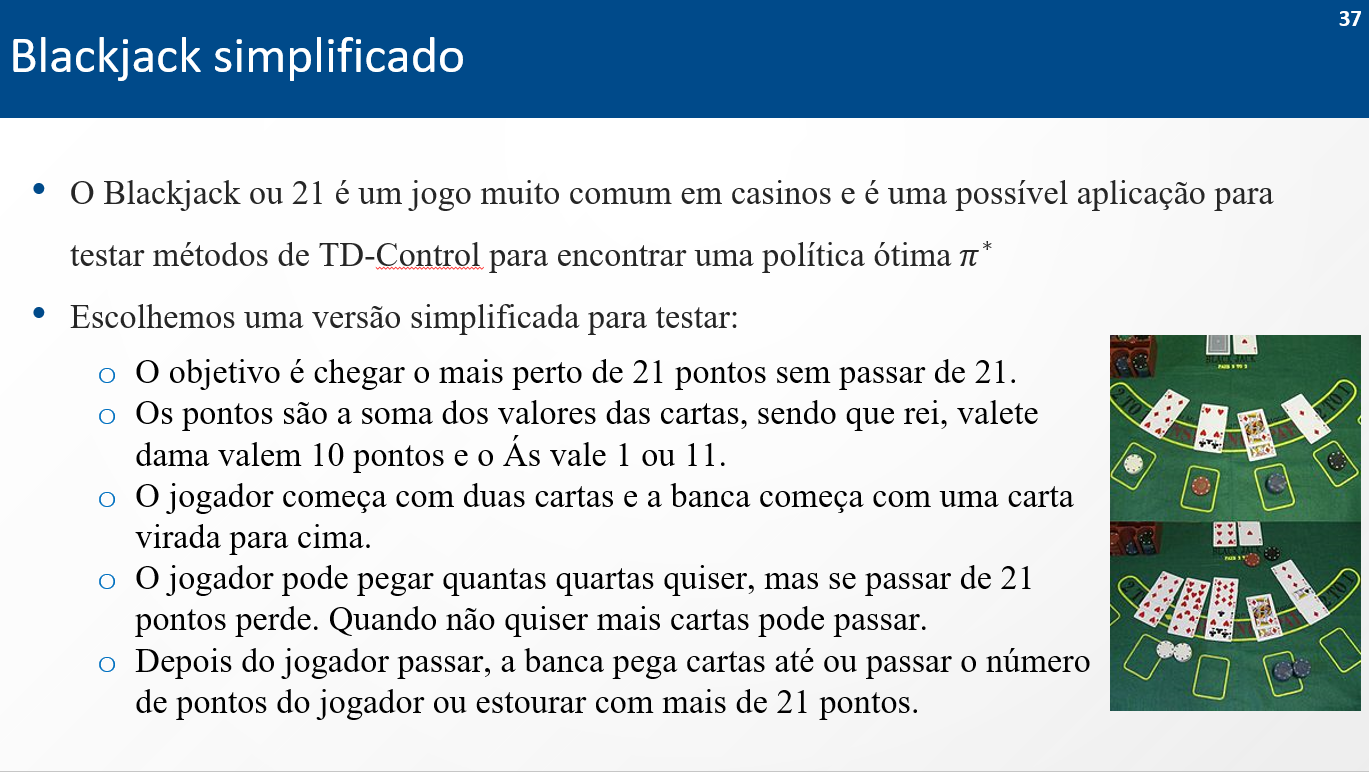

## Fonte

https://github.com/ml874/Blackjack--Reinforcement-Learning

##Algoritmo Double Q-Learning

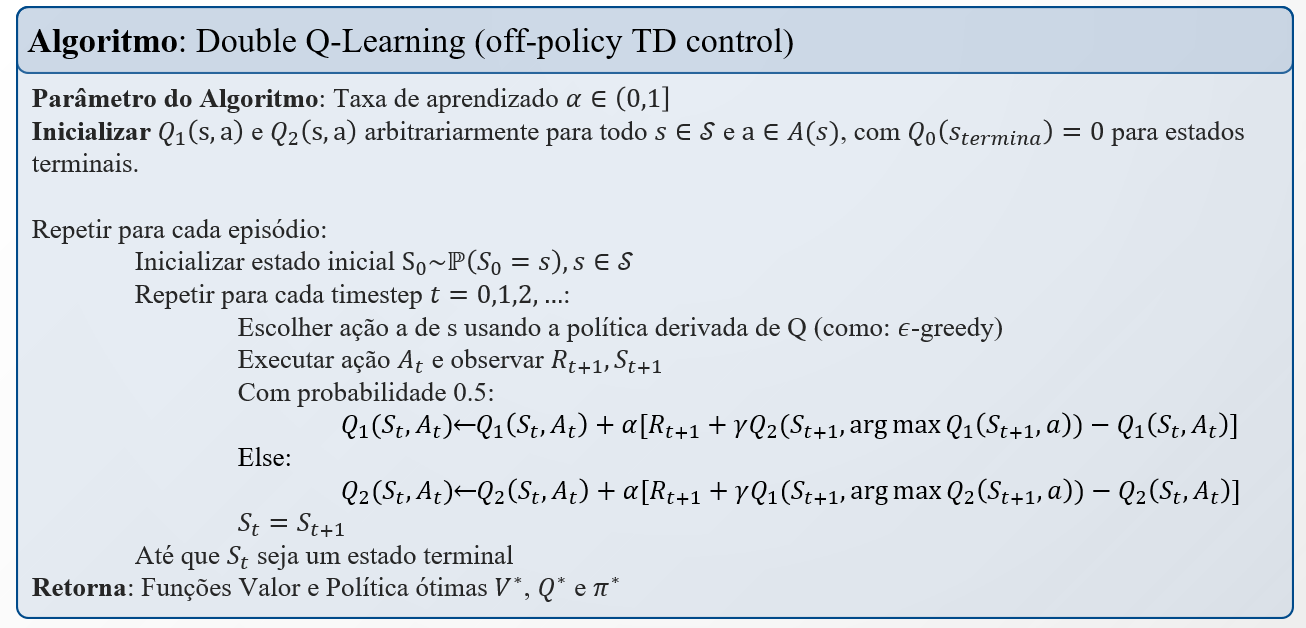

### Agent

In [1]:
import random
from collections import Counter

class Agent():
    def __init__(self, env, epsilon=0.9, alpha=0.3, gamma=0.975):
        self.env = env

        # Looks like n is number of valid actions from the souce code
        self.valid_actions = list(range(self.env.action_space.n))

        # Set parameters of the learning agent
        self.Q1 = dict()          # Q-table 
        self.Q2 = dict()          # Q-table 
        self.epsilon = epsilon   # Random exploration rate
        self.alpha = alpha       # Learning rate
        self.gamma = gamma       # Discount rate- closer to 1 learns well into distant future


    def create_Q_if_new_observation(self, observation):
        """
        Set intial Q values to 0.0 if observation not already in Q table
        """
        if observation not in self.Q1:
            self.Q1[observation] = dict((action, 0.0) for action in self.valid_actions)
            self.Q2[observation] = dict((action, 0.0) for action in self.valid_actions)
         
            
    def get_Q1argmaxQ2(self, observation):
        """
        Called when the agent is asked to find the maximum Q-value of
        all actions based on the 'observation' the environment is in.
        """
        self.create_Q_if_new_observation(observation)
        action = max(self.Q2[observation], key=self.Q2[observation].get)
        return self.Q1[observation][action]
    
    def get_Q2argmaxQ1(self, observation):
        """
        Called when the agent is asked to find the maximum Q-value of
        all actions based on the 'observation' the environment is in.
        """
        self.create_Q_if_new_observation(observation)
        action = max(self.Q1[observation], key=self.Q1[observation].get)
        return self.Q2[observation][action]

    def choose_action(self, observation):
        """
        Choose which action to take, based on the observation.
        If observation is seen for the first time, initialize its Q values to 0.0
        """
        self.create_Q_if_new_observation(observation)

        # uniformly distributed random number > epsilon happens with probability 1-epsilon
        if random.random() > self.epsilon:
            self.create_Q_if_new_observation(observation)

            sum_Q = dict(Counter(self.Q1[observation]))
            sum_Q.update(Counter(self.Q2[observation]))
            sum_Q = dict(sum_Q)
            maxQ = max(sum_Q.values())

            # multiple actions could have maxQ- pick one at random in that case
            # this is also the case when the Q value for this observation were just set to 0.0
            action = random.choice([k for k in sum_Q.keys()
                                    if sum_Q[k] == maxQ])
        else:
            action = random.choice(self.valid_actions)

        return action


    def learn(self, observation, action, reward, next_observation):
        """
        Called after the agent completes an action and receives a reward.
        This function does not consider future rewards
        when conducting learning.
        """
        if random.randint(1, 2) == 1:
            self.Q1[observation][action] += self.alpha * (reward
                                                     + (self.gamma * self.get_Q2argmaxQ1(next_observation))
                                                     - self.Q1[observation][action])
        else:
            self.Q2[observation][action] += self.alpha * (reward
                                                     + (self.gamma * self.get_Q1argmaxQ2(next_observation))
                                                     - self.Q2[observation][action])

### Final Model

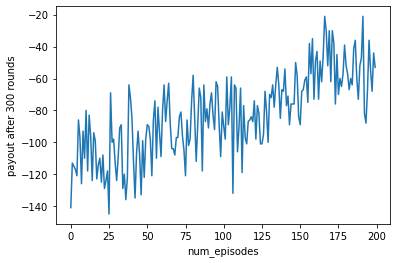

Blackjack with Double Q-Learning
Average payout after 300 rounds is -82.98


In [13]:
import gym
env = gym.make('Blackjack-v0')
# env = wrappers.Monitor(env, './logs/blackjack-Q', False, True)
import matplotlib.pyplot as plt

agent = Agent(env=env, epsilon=0.9, alpha=0.3, gamma=0.975)

num_hands = 300 # Payout calculated over num_hands
num_episodes = 200 # num_hands simulated over num_samples

average_payouts = []

observation = env.reset()
for episode in range(num_episodes):
    round = 1
    total_payout = 0 # to store total payout over 'num_hands'


    while round <= num_hands:
        action = agent.choose_action(observation)
        next_observation, payout, is_done, _ = env.step(action)
        agent.learn(observation, action, payout, next_observation)
        total_payout += payout
        observation = next_observation
        if is_done:
            observation = env.reset() # Environment deals new cards to player and dealer
            round += 1
    average_payouts.append(total_payout)
    
    # Fazendo decay dos Hiperparâmetros
    agent.epsilon -= 0.9/num_episodes
    agent.alpha -= 0.25/num_episodes

# Plot payout per 300 rounds for episode
plt.plot(average_payouts)           
plt.xlabel('num_episodes')
plt.ylabel('payout after 300 rounds')
plt.show()      
    
print("Blackjack with Double Q-Learning")
print ("Average payout after {} rounds is {}".format(num_hands, sum(average_payouts)/(num_episodes)))